In [1]:
# Importing necessary library
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import pywt
import pandas as pd
import os
import time
from scipy import signal
from stingray import lightcurve
import sys
from stingray import Bispectrum
import warnings
import csv
warnings.filterwarnings('ignore')
%matplotlib inline

c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\stingray\utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\stingray\utils.py:40: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


In [2]:
# file that will be skipped because of information loss
zeros_test = ['co2a0000368_91.csv', 'co2c0000341_26.csv']
zeros_train = ['co2a0000368_0.csv', 'co2a0000368_1.csv', 'co2a0000368_2.csv', 'co2a0000368_3.csv', 'co2a0000368_4.csv', 'co2a0000368_5.csv', 'co2c0000341_27.csv']

### Menghitung Matriks Cumulant orde ke-3

In [3]:
def calcCumulantOrde3(df_data, t, lag):
    # Compute the bispectrum of the signal
    lc = lightcurve.Lightcurve(t,df_data.T)
    bs = Bispectrum(lc, maxlag=lag)

    # Plot the bispectrum using contour plots
    # plt.contour(bs.freq, bs.freq, bs.bispec_mag)
    # plt.xlabel('f1')
    # plt.ylabel('f2')
    # plt.show()

    # fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 5))

    # # Make data.
    # X, Y = np.meshgrid(bs.freq, bs.freq)

    # # Plot the surface.
    # surf = ax.plot_surface(X, Y, bs.cum3, cmap=cm.coolwarm,
    #                     linewidth=0, antialiased=True)

    # # Customize the z axis.
    # # ax.set_zlim(-1.01, 1.01)
    # ax.zaxis.set_major_locator(LinearLocator(10))
    # # A StrMethodFormatter is used automatically
    # ax.zaxis.set_major_formatter('{x:.02f}')

    # # Add a color bar which maps values to colors.
    # fig.colorbar(surf, shrink=0.5, aspect=5)

    # plt.show()
    # Plot the bispectrum using mesh plots
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # X, Y = np.meshgrid(bs.freq, bs.freq)
    # ax.plot_surface(X, Y, bs.cum3)
    # ax.set_xlabel('f1')
    # ax.set_ylabel('f2')
    # ax.set_zlabel('Bispectrum')
    # plt.show()

    return bs

### Melakukan dekomposisi wavelet

In [4]:
def calcWaveletDec(bs):
    # Select wavelet and decomposition level
    wavelet = 'db4'
    level = 5

    # Deecompose signal
    coeffs = pywt.wavedec2(bs.cum3, wavelet, level=level)
    # Plot the bispectrum using mesh plots
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # X, Y = np.meshgrid(np.arange(len(coeffs[0])), np.arange(len(coeffs[0][0])))
    # ax.plot_surface(X, Y, coeffs[0])
    # ax.set_xlabel('f1')
    # ax.set_ylabel('f2')
    # ax.set_zlabel('Bispectrum')
    # plt.show()

    x, y = np.meshgrid(np.arange(len(coeffs[0])), np.arange(len(coeffs[0][0])))
    z = coeffs[0]
    z = z[:-1, :-1]
    z_min, z_max = -np.abs(z).max(), np.abs(z).max()
    
    plt.subplot()
    
    plt.pcolormesh(x, y, z, 
                cmap =cm.coolwarm, 
                vmin = z_min, 
                vmax = z_max,
                edgecolors = 'face',
                shading ='flat')
    
    plt.title('Approximation')
    
    # set the limits of the plot
    # to the limits of the data
    plt.axis([x.min(), x.max(), y.min(), y.max()])
    
    plt.colorbar()
    plt.show()

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 5))

    # # Make data.
    X, Y = np.meshgrid(np.arange(len(coeffs[0])), np.arange(len(coeffs[0][0])))

    # Plot the surface.
    surf = ax.plot_surface(X, Y, coeffs[0], cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)

    # Customize the z axis.
    # ax.set_zlim(min(coeffs[0].all()), max(coeffs[0].all()))
    ax.zaxis.set_major_locator(LinearLocator(5))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.75, aspect=20)
    # Visualize
    plt.show()
    
    cA5 = coeffs[0][np.triu(np.ones_like(coeffs[0], dtype=bool))]
    cD5 = np.ravel([coeffs[1][0], coeffs[1][1], coeffs[1][2]])
    cD4 = np.ravel([coeffs[2][0], coeffs[2][1], coeffs[2][2]])
    cD3 = np.ravel([coeffs[3][0], coeffs[3][1], coeffs[3][2]])
    cD2 = np.ravel([coeffs[4][0], coeffs[4][1], coeffs[4][2]])
    cD1 = np.ravel([coeffs[5][0], coeffs[5][1], coeffs[5][2]])
    
    coeff = [cA5,cD5,cD4,cD3,cD2,cD1]
    print(cA5)
    
    plt.figure(figsize=(10,6))
    plt.plot(np.arange(len(cD5)), cD5, color = 'k', linewidth=1)
    plt.title(f'Detail - Level 5')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(np.arange(len(cD4)), cD4, color = 'k', linewidth=1)
    plt.title(f'Detail - Level 4')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(np.arange(len(cD3)), cD3, color = 'k', linewidth=1)
    plt.title(f'Detail - Level 3')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(np.arange(len(cD2)), cD2, color = 'k', linewidth=1)
    plt.title(f'Detail - Level 2')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(np.arange(len(cD1)), cD1, color = 'k', linewidth=1)
    plt.title(f'Detail - Level 1')
    plt.show()


    return coeffs


### Menghitung energi relatif

In [10]:
def calcRelativeEnergy(coeffs, df_data):
    # Calculate relative wavelet energy
    energies = []
    for c in coeffs:
        energies.append(np.sum(np.square(c)))

    decomp = ['A5', 'D1', 'D2', 'D3', 'D4', 'D5']

    energies[1:6] = energies[-1:-6:-1]

    total_energy = np.sum(energies)
    relative_energies = [(e / total_energy) * 100 for e in energies]

    # print(relative_energies)

    # plt.plot(decomp, energies)
    # plt.xlabel('Dimension Number')
    # plt.ylabel('Wavelet Bispectrum Energy')
    # plt.show()
    plt.figure(figsize=(10,6))
    plt.plot(decomp, relative_energies, color = 'k', linewidth=1)
    plt.xlabel('Dimension Number')
    plt.ylabel('Relative Wavelet Bispectrum Energy')
    plt.show()

    return energies, relative_energies

### Persiapan data

In [6]:
# Define sampling frequency
fs = 256
t = np.arange(0, 1, 1/fs)

def get_csv_EEG(filename):
    # Load data from CSV
    data = np.loadtxt(filename, delimiter=",", skiprows=1, usecols=range(3,259))
    channel_name = np.loadtxt(filename, delimiter=",", skiprows=1, usecols=1, dtype='str', encoding='utf-8')
    
    df_data = pd.DataFrame(data.T, columns=channel_name)

    df_data = df_data.drop(columns=['X', 'Y', 'nd'])

    return df_data, df_data.columns


### Perhitungan RWB

In [7]:
def extract_feature(directory, lag):
    recap = pd.DataFrame(columns=['Wall Time', 'CPU Time'])
    for foldername in os.listdir(directory):
        folder = os.path.join(directory, foldername)
        if os.path.isdir(folder):
            des_dir = os.path.join(directory.replace('CSV', 'FEATURE')+"_" + str(lag),foldername).lower()
            files = os.listdir(folder)
            for filename in files:
                cpu_start = time.process_time()
                wt_start = time.time()
                if filename in zeros_train or filename in zeros_test:
                    continue
                rel_path = os.path.join(directory, foldername, filename)
                if 'metadata' in filename.lower():
                    continue
                trial_number = filename.split('.')[0].split('_')[1]
                df_data, channel_name = get_csv_EEG(rel_path)
                des_file = foldername+'_'+ str(trial_number) + '_bispectrum' +'.npy'
                if not os.path.exists(des_dir):
                    os.makedirs(des_dir)
                des_path = os.path.join(des_dir, des_file)
                if os.path.exists(des_path):
                    continue
                RWB = []
                for channel in channel_name:
                    y = df_data[channel]; # sinyal per channel
                    # N = len(y);
                    # z = y - np.mean(y);
                    # nsamp = len (y[0])
                    energies, relative_energies = calcRelativeEnergy(calcWaveletDec(calcCumulantOrde3(y, t, lag)), y)
                    for x in relative_energies:
                        RWB.append(x)
                RWB = np.array(RWB)
                np.save(des_path, RWB)
                wt_end = time.time()
                cpu_end = time.process_time()
                wall_time = wt_end - wt_start
                cpu_time = cpu_end - cpu_start
                recap_temp = pd.DataFrame([[wall_time, cpu_time]],columns=recap.columns)
                recap = pd.concat([recap, recap_temp], ignore_index=True)
                # pd.DataFrame(RWB.T).to_csv(des_path, index=False)
    recap_dir = os.path.join('./logs/Execution',directory.split('/')[1])
    if not os.path.exists(recap_dir):
        os.makedirs(recap_dir)
    recap_path = os.path.join(recap_dir,'recap_rwb'+str(lag)+'.csv')
    recap.to_csv(recap_path)


### Mengecek nilai nol pada data

In [8]:
def check_zeros(directory):
    contain_zero = []
    for foldername in os.listdir(directory):
        folder = os.path.join(directory, foldername)
        if os.path.isdir(folder):
            files = os.listdir(folder)
            for filename in files:
                rel_path = os.path.join(directory, foldername, filename)
                if 'metadata' in filename.lower():
                    continue
                df_data, channel_name = get_csv_EEG(rel_path)
                for channel in channel_name:
                    if (df_data[channel]== 0).all():
                        contain_zero.append(filename)
                        break
    return contain_zero

### Testing

In [8]:
def get_dummy(directory, lag):
    for foldername in os.listdir(directory):
        folder = os.path.join(directory, foldername)
        if os.path.isdir(folder):
            des_dir = os.path.join(directory.replace('CSV', 'FEATURE')+"_" + str(lag),foldername).lower()
            files = os.listdir(folder)
            for filename in files:
                rel_path = os.path.join(directory, foldername, filename)
                if 'metadata' in filename.lower():
                    continue
                trial_number = filename.split('.')[0].split('_')[1]
                df_data, channel_name = get_csv_EEG(rel_path)
                RWB = []
                return df_data[channel_name[0]]
                # pd.DataFrame(RWB.T).to_csv(des_path, index=False)
        


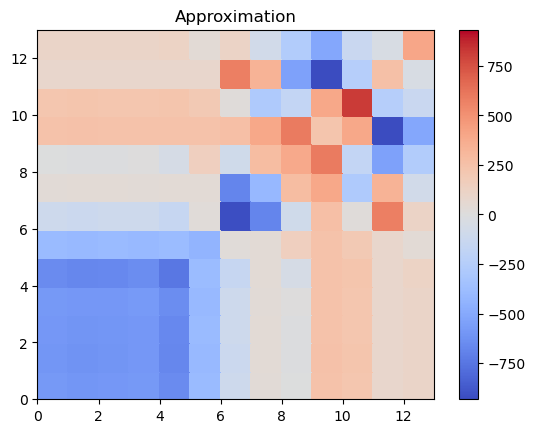

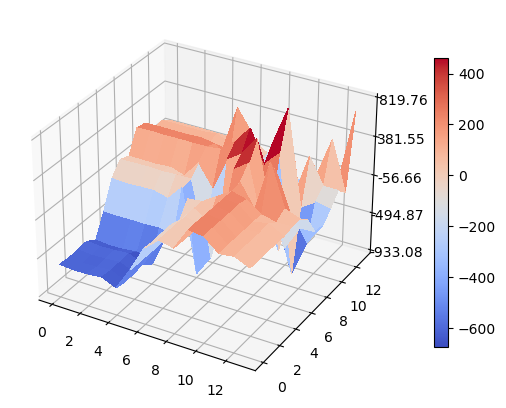

[-589.68060736 -602.55143543 -597.08975805 -583.58969725 -655.83429051
 -398.73628115 -104.9634053    34.59939427   -4.59433436  244.67736736
  223.44608654   83.95259457  103.91694398   29.82656494 -616.19820061
 -610.16051333 -596.34196149 -671.89209333 -402.37245888 -117.06845457
   38.87834361   -8.53483158  249.70171064  226.24289936   86.46867099
  105.2979524    28.81509397 -604.84206553 -590.6348124  -665.52430406
 -399.1375752  -107.87499502   39.98981242   -9.8518876   244.358079
  223.20462392   84.67827863  103.64813304   31.48236945 -577.98112073
 -647.08872912 -401.18789549 -105.16957825   32.25448777    2.76376331
  247.84195038  223.20583163   85.64157087  102.14811995   29.7562453
 -745.71051209 -391.16804793 -149.13972476   43.02258935  -52.51482466
  246.56629412  231.40043151   85.96417622  120.15613656   25.09374194
 -440.05842229   25.06848565   41.69556228  147.4237625   245.58233772
  202.21885789   83.36199083   43.63832257   47.84802337 -922.56676222
 -679.089

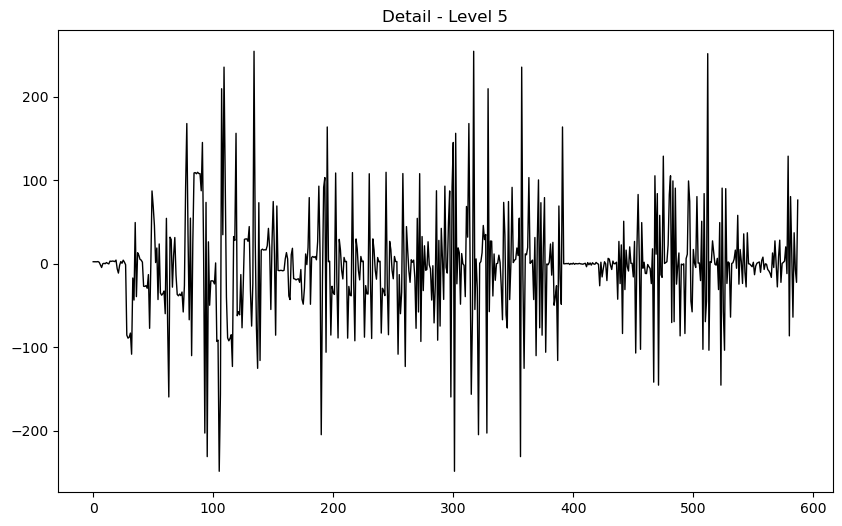

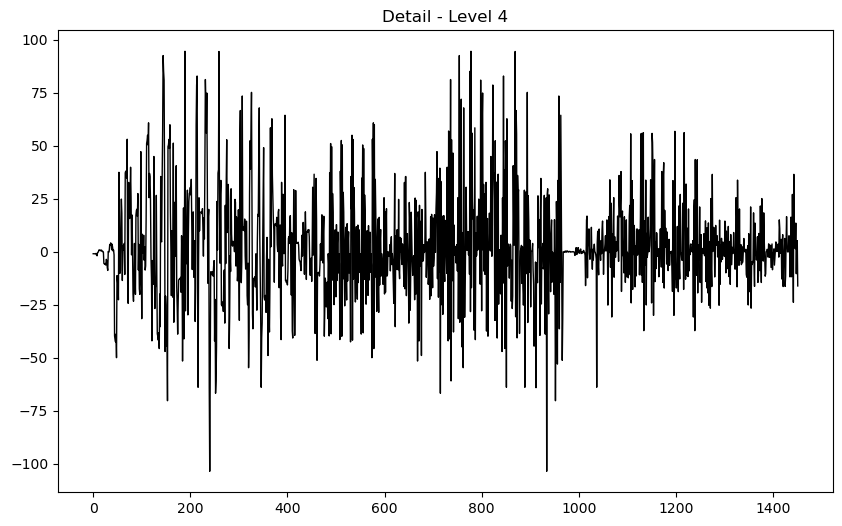

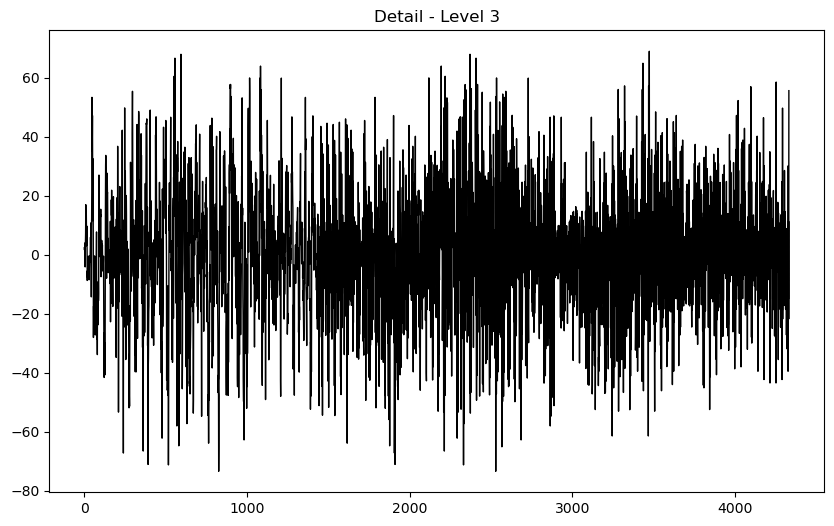

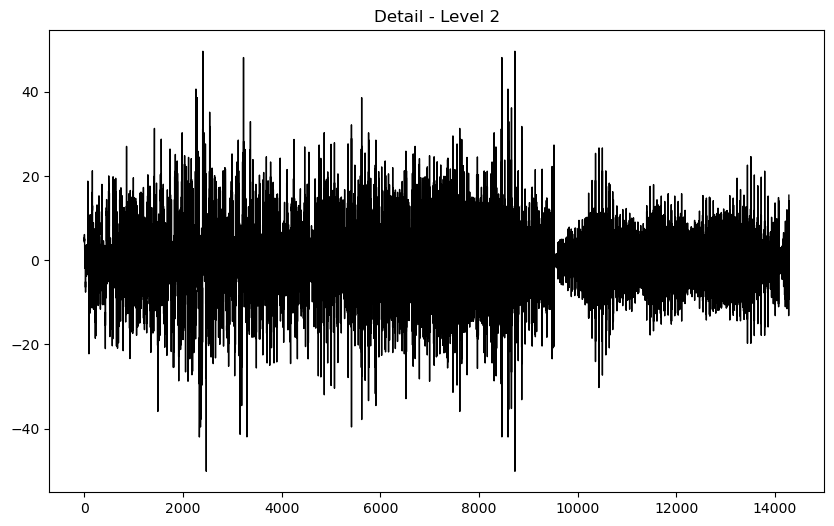

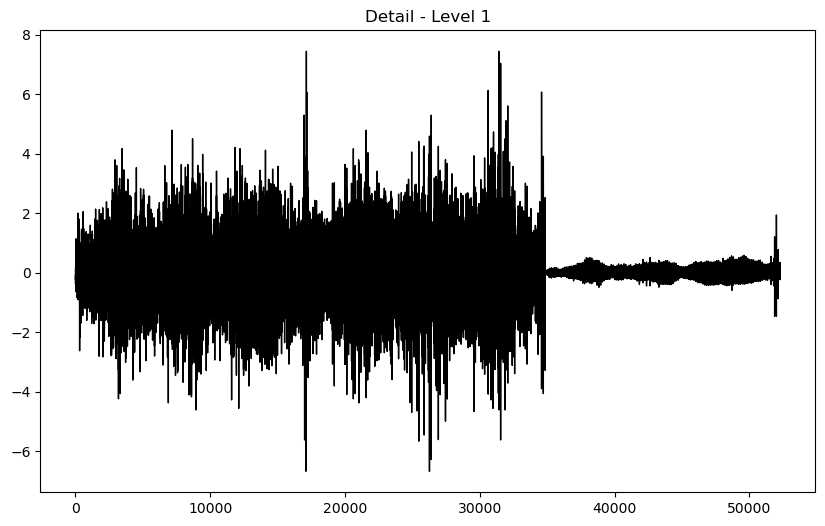

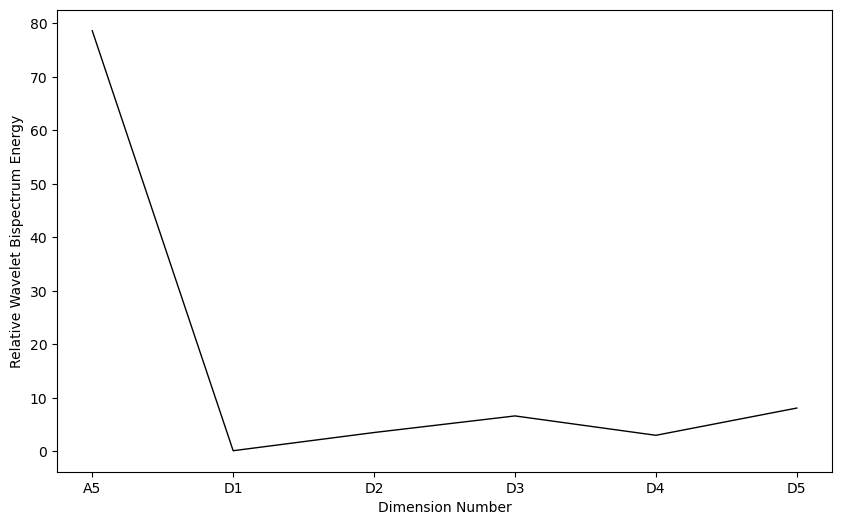

In [11]:
lag = 128
dummy = get_dummy('../SMNI_CMI_TEST_CSV', lag)
relative_energies = calcRelativeEnergy(calcWaveletDec(calcCumulantOrde3(dummy, t, lag)), dummy)


### Main Program

In [10]:
lags = [256, 128, 64, 32, 16, 8, 4, 2]
for lag in lags:
    extract_feature('../SMNI_CMI_TEST_CSV', lag)
    extract_feature('../SMNI_CMI_TRAIN_CSV', lag)